In [1]:
from qiskit.circuit.library import RealAmplitudes

In [2]:
from qiskit import QuantumCircuit, transpile

In [3]:
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
import numpy as np

In [231]:
from sklearn import datasets

In [1156]:
digits = datasets.load_digits()

In [1157]:
digits['data']

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [1158]:
zeros_data=digits['data'][digits['target'].argsort()][0:100]

In [1159]:
ones_data=digits['data'][digits['target'].argsort()][177+1:177+101]

In [1160]:
zeros_label=digits['target'][digits['target'].argsort()][0:100]

In [1161]:
ones_label=digits['target'][digits['target'].argsort()][177+1:177+101]

In [1162]:
data=np.vstack((zeros_data,ones_data))

In [1163]:
label=np.hstack((zeros_label,ones_label))

In [1164]:
label.shape

(200,)

In [1165]:
zeros_data_test=digits['data'][digits['target'].argsort()][100:110]
ones_data_test=digits['data'][digits['target'].argsort()][177+101:177+111]
zeros_label_test=digits['target'][digits['target'].argsort()][100:110]
ones_label_test=digits['target'][digits['target'].argsort()][177+101:177+111]
data_test=np.vstack((zeros_data_test,ones_data_test))
label_test=np.hstack((zeros_label_test,ones_label_test))

In [1166]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

In [1167]:
tsvd = TruncatedSVD(n_components=2)
data = tsvd.fit_transform(data)

In [1168]:
tsvd = TruncatedSVD(n_components=2)
data_test = tsvd.fit_transform(data_test)

In [1169]:
data=data/data.max()

In [1170]:
data_test=data_test/data_test.max()

In [4]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

In [5]:
def bce(predict,label):
    return -(label*np.log(predict)+(1-label)*np.log(1-predict))

In [748]:
feature_dim = 2
pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY']).decompose()

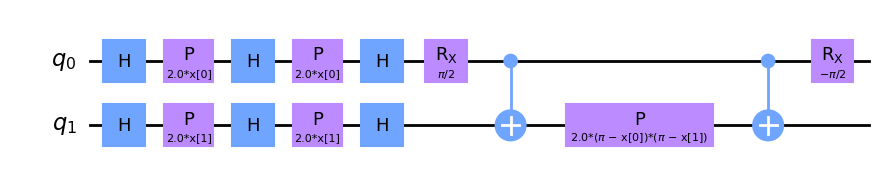

In [749]:
pauli_feature_map.draw(output="mpl")

In [750]:
ansatz=RealAmplitudes(num_qubits=2,reps=1,entanglement="linear").decompose()

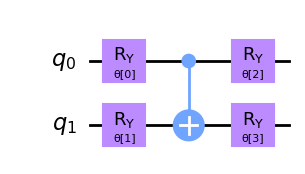

In [751]:
ansatz.draw(output='mpl')

In [752]:
circuit = QuantumCircuit(2, 1)

In [753]:
circuit = circuit.compose(pauli_feature_map,[0,1])

In [754]:
circuit = circuit.compose(ansatz,[0,1])

In [755]:
circuit.measure([0],[0])

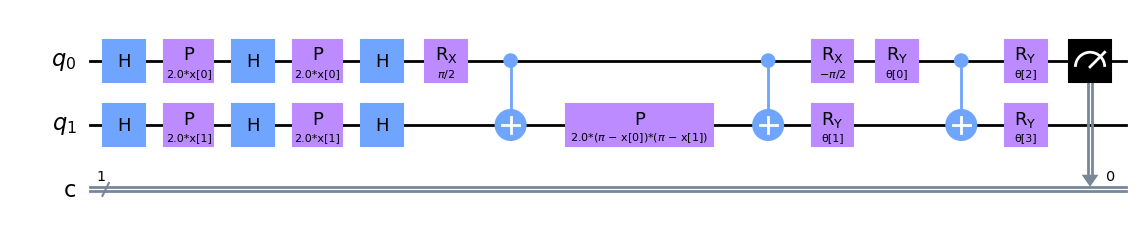

In [756]:
circuit.draw(output='mpl')

In [925]:
def get_output(circuit,x,para):
    value_dict_1 = dict(zip(pauli_feature_map.parameters,x))
    value_dict_2 = dict(zip(ansatz.parameters,para))
    value_dict=Merge(value_dict_1, value_dict_2)
    new_cq=circuit.assign_parameters(value_dict, inplace=False)
    simulator = QasmSimulator()
    compiled_circuit = transpile(new_cq, simulator)
    job = simulator.run(compiled_circuit, shots=1000)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    keys = list(counts.keys())
    if len(counts)==1:
        if keys[0]=='1':
            return 1
        if keys[0]=='0':
            return 0
    else:
        predict = counts['1']/(counts['1']+counts['0'])
        return predict

In [926]:
def get_loss(circuit,x,para,y):
    output=get_output(circuit,x,para)
    return np.abs(output-y)

In [997]:
def gradient_calculate(circuit,x,para,y,index,eps=np.pi/2):
    e_i = np.identity(para.size)[:,index]
    plus = para + eps*e_i
    minus = para - eps*e_i
    gradient = (get_loss(circuit,x,plus,y)-get_loss(circuit,x,minus,y))/2
    return gradient

In [1135]:
def gradient_decent(circuit,x,para,y):
    para_new = np.copy(para)
    for index in range(len(para)): 
        gradient = gradient_calculate(circuit,x,para,y,index)
        para_new[index] = para[index] - 0.1*gradient
    return para_new

In [1132]:
para = np.random.random(ansatz.num_parameters)

In [1133]:
para

array([0.12749859, 0.74726459, 0.14879192, 0.29729374])

In [1134]:
get_loss(circuit,data[0],para,label[0])

0.587

In [1002]:
para_new=gradient_decent(circuit,data[0],para,label[0])

In [1003]:
get_loss(circuit,data[0],para_new,label[0])

0.22799999999999998

In [1020]:
para_new=gradient_decent(circuit,data[0],para_new,label[0])

In [1021]:
get_loss(circuit,data[0],para_new,label[0])

0.010000000000000009

data=[[0,0],[1,1],[2,2],[3,3],[4,4],[5,5]]
label=[0,0,0,1,1,1]
label=np.array(label)

In [1148]:
para = np.random.random(ansatz.num_parameters)

In [1172]:
for i in range(5):
    for j in range(len(label)):
        x=data[j]
        y=label[j]
        para=gradient_decent(circuit,x,para,y)
    predicts=[]   
    for j in range(len(label_test)):
        x=data_test[j]
        y=label_test[j]
        predict = get_output(circuit,x,para)
        if predict<0.5:
            predicts.append(0)
        else:
            predicts.append(1)
    predicts=np.array(predicts)
    #loss=np.abs((predicts-label)).mean()
    #print(loss)
    print((predicts==label_test).sum()/len(predicts))

0.95
0.95
0.95
0.95


KeyboardInterrupt: 